In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf

from tensorflow.keras.layers import (
    Input,
    Dense,
    Flatten,
    Reshape,
    Conv2D,
    MaxPooling2D,
    UpSampling2D
)

from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MeanSquaredError

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
print(f"Tensorflow datasets: {tfds.__version__}")
print(f"Tensorflow: {tf.__version__}")
print(f"Numpy: {np.__version__}")
print(f"Matplotlib: {matplotlib.__version__}")

Tensorflow datasets: 4.2.0
Tensorflow: 2.4.1
Numpy: 1.19.5
Matplotlib: 3.4.1


In [3]:
import pump
data_dir = "../dataset"

(train, test), info = tfds.load('pump', split=["train", "test"], data_dir=data_dir, with_info=True)

In [4]:
tfds.as_dataframe(train.take(1), info)

audio audio/id audio/machine  \
0  [370, 481, 528, 413, 367, 375, 324, 247, 111, ...  b'0774'         b'02'   

   audio/split  label  
0            0      0

In [5]:
df = tfds.as_dataframe(train.take(5), info)
df.head()

,audio,audio/id,audio/machine,audio/split,label
0,"[370, 481, 528, 413, 367, 375, 324, 247, 111, ...",b'0774',b'02',0,0
1,"[-308, -105, 33, -72, -164, -198, -322, -276, ...",b'0550',b'02',0,0
2,"[91, 79, 22, -29, -22, 27, 63, 266, 551, 518, ...",b'0604',b'06',0,0
3,"[78, 201, 252, 175, 152, 223, 130, -38, -129, ...",b'0483',b'06',0,0
4,"[162, 165, 166, 24, -64, -500, -450, -518, -53...",b'0371',b'06',0,0


In [6]:
(train, test), info = tfds.load('pump', split=["train", "test"], as_supervised=True, data_dir=data_dir, with_info=True)

In [7]:
tfds.as_dataframe(train.take(1), info)

audio  label
0  [370, 481, 528, 413, 367, 375, 324, 247, 111, ...      0

In [8]:
A = tf.signal.linear_to_mel_weight_matrix(
    num_mel_bins=128, num_spectrogram_bins=256+1, sample_rate=16000, dtype=tf.float32
)

In [9]:
def mel(audio, label):
    audio = tf.cast(audio, tf.float32)
    audio = audio / 2**15

    stfts = tf.signal.stft(
            audio,
            frame_length=512,
            frame_step=256,
            pad_end=False,  # librosa test compatibility
        )
    mag_stfts = tf.abs(stfts)

    melgrams = tf.tensordot(
            tf.square(mag_stfts), A, axes=1
    )

    def _tf_log10(x):
        numerator = tf.math.log(x)
        denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
        return numerator / denominator
        
    log_melgrams = _tf_log10(melgrams + 10e-6)
    return log_melgrams, log_melgrams,

In [10]:
BATCH_SIZE = 16
SHUFFLE_BUFFER_SIZE = 32

audio_train = train.map(mel).batch(BATCH_SIZE)
label_train = train.map(lambda _, label: label).batch(BATCH_SIZE)

audio_test = test.map(mel).batch(BATCH_SIZE)
label_test = test.map(lambda _, label: label).batch(BATCH_SIZE)

In [11]:
audio_train.unbatch().take(1)

<TakeDataset shapes: ((624, 128), (624, 128)), types: (tf.float32, tf.float32)>

In [15]:
autoencoder = tf.keras.Sequential(
    [
        Reshape((624, 128,1),input_shape=(624, 128)),
        # Input(shape=(311, 128, 1)),
        Conv2D(filters=64, kernel_size=(2,2), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(4,4)),
        Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same'),
        Conv2D(filters=1, kernel_size=(3,3), activation='sigmoid', padding='same'),
        Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'),
        UpSampling2D(size=(2,2)),
        Conv2D(filters=4, kernel_size=(3,3), activation='relu', padding='same'),
        UpSampling2D(size=(4,4)),
        Conv2D(filters=1, kernel_size=(3,3), activation='sigmoid', padding='same')
    ]
)

autoencoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 624, 128, 1)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 624, 128, 64)      320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 156, 32, 64)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 156, 32, 128)      73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 78, 16, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 78, 16, 256)       295168    
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 78, 16, 1)        

In [16]:
autoencoder.compile(optimizer='adam', loss=MeanSquaredError())

In [17]:
history = autoencoder.fit(audio_train,
                epochs=10,
                shuffle=True,
                validation_data=audio_test)

Epoch 1/10
210/210 [==============================] - 114s 539ms/step - loss: 5.8474 - val_loss: 5.1024
Epoch 2/10
210/210 [==============================] - 112s 534ms/step - loss: 5.4451 - val_loss: 5.1024
Epoch 3/10
210/210 [==============================] - 112s 533ms/step - loss: 5.4451 - val_loss: 5.1024
Epoch 4/10
210/210 [==============================] - 112s 531ms/step - loss: 5.4451 - val_loss: 5.1024
Epoch 5/10
210/210 [==============================] - 112s 534ms/step - loss: 5.4451 - val_loss: 5.1024
Epoch 6/10
210/210 [==============================] - 112s 533ms/step - loss: 5.4451 - val_loss: 5.1024
Epoch 7/10
210/210 [==============================] - 112s 533ms/step - loss: 5.4451 - val_loss: 5.1024
Epoch 8/10
210/210 [==============================] - 112s 534ms/step - loss: 5.4451 - val_loss: 5.1024
Epoch 9/10
210/210 [==============================] - 112s 533ms/step - loss: 5.4451 - val_loss: 5.1024
Epoch 10/10
210/210 [==============================] - 112s 531m

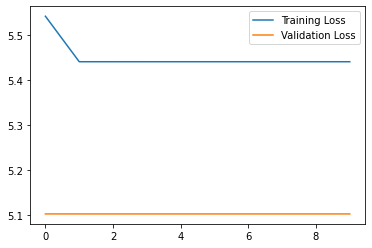

In [18]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

In [ ]:
# reconstructions = autoencoder.predict(audio_train)
# audio_train2 = np.stack(audio_train.unbatch().map(lambda x, _: x), axis=1).T

# train_loss = tf.keras.losses.mae(audio_train2, reconstructions)

# plt.hist(train_loss, bins=10)
# plt.xlabel("Train loss")
# plt.ylabel("No of examples")
# plt.show()

In [ ]:
# threshold = np.mean(train_loss) + np.std(train_loss)
# print(threshold)

In [ ]:
# reconstructions = autoencoder.predict(audio_test)
# audio_test2 = np.stack(audio_test.unbatch().map(lambda x, _: x), axis=1).T

# test_loss = custom_loss(audio_test2, reconstructions)

# plt.hist(test_loss, bins=10)
# plt.xlabel("Test loss")
# plt.ylabel("No of examples")
# plt.show()